In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to add noise to the images
class AddNoiseTransform:
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def __call__(self, img):
        noisy_img = img + self.noise_level * torch.randn_like(img)
        return noisy_img, img

transform = transforms.Compose([
    transforms.ToTensor(),
    AddNoiseTransform(noise_level=0.1)
])

# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_kernel = ScaleKernel(RBFKernel())
        self.covar_module = GridInterpolationKernel(self.base_kernel, grid_size=100, num_dims=28*28)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(None, None, likelihood).to(device)


KeyboardInterrupt: 

Image Shape: (64, 28, 28)
Image Shape: (64, 28, 28)


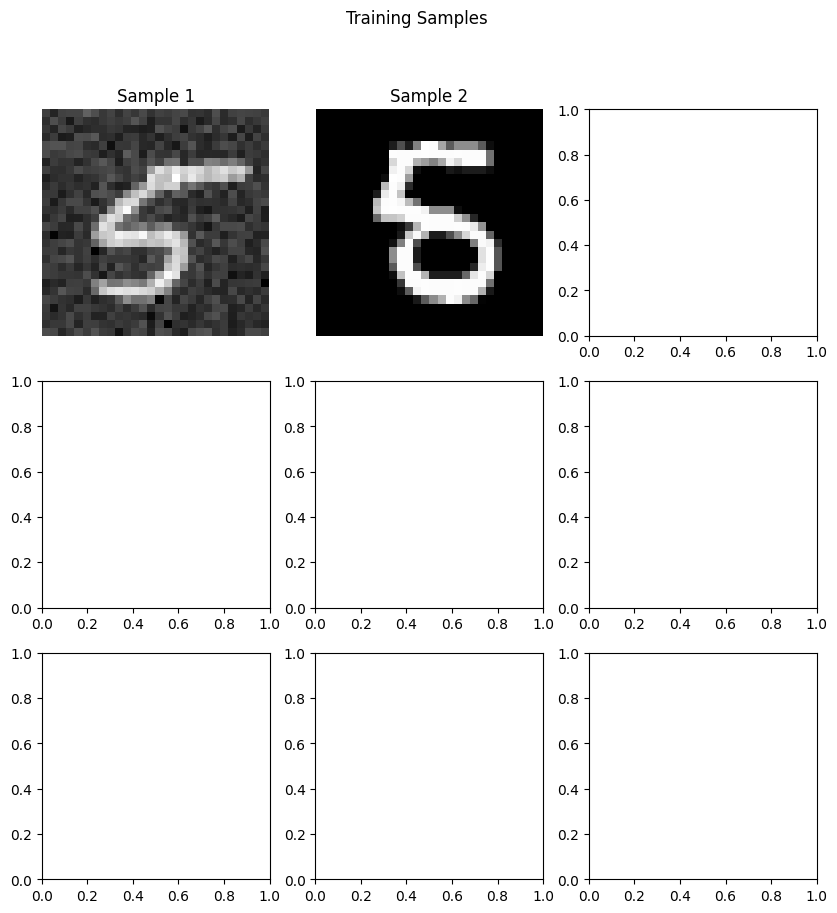

Image Shape: (64, 28, 28)
Image Shape: (64, 28, 28)


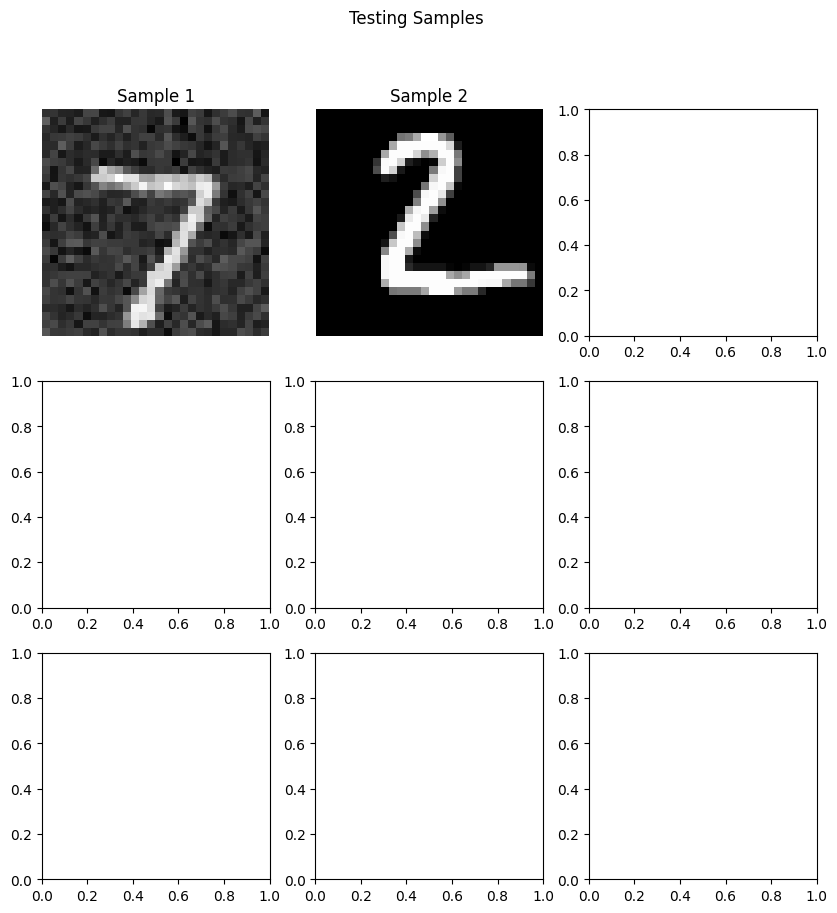

In [17]:
import matplotlib.pyplot as plt
import torchvision

def plot_samples(loader, title):
    # Get a batch of data
    data_iter = iter(loader)
    images, _ = next(data_iter)
    
    # Plot the images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            # Convert the tensor to numpy array and transpose it to (height, width, channels) format
            img_np = images[i].numpy().squeeze()  # Remove single-dimensional entries from the shape of an array
            print("Image Shape:", img_np.shape)
            ax.imshow(img_np[i,:,:], cmap='gray')
            ax.set_title(f'Sample {i+1}')
            ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot samples from the training dataset
plot_samples(train_loader, 'Training Samples')

# Plot samples from the testing dataset
plot_samples(test_loader, 'Testing Samples')



In [ ]:

def train(train_loader):
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    for epoch in range(5):  # Loop over the dataset multiple times
        for i, (inputs, targets) in enumerate(train_loader):
            noisy_images, clean_images = inputs
            print(noisy_images.shape)
            noisy_images = noisy_images.view(-1, 28*28).to(device)
            print(noisy_images.shape)
            clean_images = clean_images.view(-1, 28*28).to(device)
            print(clean_images.shape)
            
            model.set_train_data(noisy_images, clean_images, strict=False)
            
            optimizer.zero_grad()
            output = model(noisy_images)
            loss = -mll(output, clean_images)
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}')

train(train_loader)

def predict(test_loader):
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        for i, (inputs, targets) in enumerate(test_loader):
            noisy_images, clean_images = inputs
            noisy_images = noisy_images.view(-1, 28*28).to(device)
            clean_images = clean_images.view(-1, 28*28).to(device)
            
            preds = likelihood(model(noisy_images))
            mean = preds.mean.view(-1, 1, 28, 28).cpu()
            
            # Visualize the predictions and ground truth
            # This is a simplified example; in practice, you might want to save the images or perform more sophisticated visualization.
            if i == 0:
                import matplotlib.pyplot as plt
                fig, axes = plt.subplots(1, 2)
                axes[0].imshow(noisy_images[0].view(28, 28).cpu(), cmap='gray')
                axes[0].set_title('Noisy Input')
                axes[1].imshow(mean[0].view(28, 28), cmap='gray')
                axes[1].set_title('Denoised Output')
                plt.show()
                break

predict(test_loader)


torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 784])


RuntimeError: The size of tensor a (784) must match the size of tensor b (64) at non-singleton dimension 1

# Index Kernels

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

train_x1 = torch.rand(50)
train_x2 = torch.rand(50)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2


class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_i_task1 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x2.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x1, train_x2])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y1, train_y2])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [3]:
full_train_i.shape, full_train_x.shape, full_train_y.shape

(torch.Size([100, 1]), torch.Size([100]), torch.Size([100]))

# Essential Practice on GPytorch and LazyTensor in GPytorch

In [4]:
import torch 
import gpytorch
from gpytorch.lazy import LazyTensor, KroneckerProductLazyTensor, MatmulLazyTensor

In [5]:
# creating and lazytensor
tensor_1 = torch.randn(3,3)
lazy_tesnor_1 = LazyTensor(tensor_1)
print(lazy_tesnor_1, lazy_tesnor_1.dtype)

<linear_operator.operators._linear_operator.LinearOperator object at 0x7f962c601b80> torch.float32


In [20]:
# Creating a covariance matrix 
from gpytorch.kernels import RBFKernel

train_x = torch.tensor([
    [1,2],[2,4],[5,7]
])
print(train_x.shape, train_x.dtype)

kernel = RBFKernel()
cov_mat = kernel(train_x)
lazy_cov_mat = LazyTensor(cov_mat.evaluate())
print(lazy_cov_mat.to_dense)

torch.Size([3, 2]) torch.int64
<bound method LinearOperator.to_dense of <linear_operator.operators._linear_operator.LinearOperator object at 0x7f9536bb6f40>>


In [46]:
from gpytorch.kernels import IndexKernel

num_outputs = 2
covar_nn = RBFKernel()
covar_oo = IndexKernel(num_tasks=num_outputs)

cov_x = covar_nn(train_x)
cov_o = covar_oo.covar_matrix  # directly evaluates the cov_o

# Kronecker product 
kron_cov = KroneckerProductLazyTensor(cov_x,cov_o)
print(kron_cov.shape)

torch.Size([6, 6])


In [47]:
# matrix operation with lazy tensor
# Matrix vector product
vec = torch.randn(6)
lazy_vec = LazyTensor(vec)
# mat_vec = lazy_cov_mat@lazy_vec
 # not working as if use define a lazytensor then it doesn't mean all the methods exists already like .shape, @, inv_mat etc. You'll have to define it in custom Lazytensor class

In [61]:
inv_result = kron_cov.log_det() # not working
print(inv_result)
mat_mul = kron_cov@vec
mat_inv = kron_cov.inv_matmul(vec)
print(mat_inv.shape,mat_mul.shape)
print(kron_cov.evaluate()) # to print evaluate() method is used

tensor(-1.6002, grad_fn=<SumBackward1>)
torch.Size([6]) torch.Size([6])
tensor([[1.0117, 0.6032, 0.3573, 0.2131, 0.0157, 0.0094],
        [0.6032, 1.0595, 0.2131, 0.3742, 0.0094, 0.0165],
        [0.3573, 0.2131, 1.0117, 0.6032, 0.3573, 0.2131],
        [0.2131, 0.3742, 0.6032, 1.0595, 0.2131, 0.3742],
        [0.0157, 0.0094, 0.3573, 0.2131, 1.0117, 0.6032],
        [0.0094, 0.0165, 0.2131, 0.3742, 0.6032, 1.0595]],
       grad_fn=<MatmulBackward>)


In [56]:
# Simple multioutput GP exploiting the use of LazyTensor
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import MultitaskMean
from gpytorch.lazy import KroneckerProductLazyTensor

class MOGP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x,train_y,likelihood)

        num_task = train_y.shape[-1]

        self.cov_x = RBFKernel()
        self.cov_o = IndexKernel(num_tasks=num_task, rank=1)
        self.mean = MultitaskMean(gpytorch.means.ConstantMean(), num_tasks=num_task)

    def forward(self,x):
        mean_x = self.mean(x)
        cov_nn = self.cov_x(x)
        cov_oo = self.cov_o.covar_matrix
        kron_covar = KroneckerProductLazyTensor(cov_nn,cov_oo)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x,kron_covar)

# Define training data
train_x = torch.tensor([[1.0], [2.0], [3.0]])
train_y = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

num_outputs = train_y.shape[-1]
likelihood = MultitaskGaussianLikelihood(num_tasks=num_outputs)

model = MOGP(train_x=train_x,train_y=train_y, likelihood=likelihood)

mll = ExactMarginalLogLikelihood(likelihood=likelihood,model=model)
output = model(train_x)
lazy_cov_matrix = output.lazy_covariance_matrix

# Print the shape of the LazyTensor
print("LazyTensor shape:", lazy_cov_matrix.shape)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for i in range(10):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output,train_y)
    loss.backward()
    optimizer.step()
    print(i)
    


LazyTensor shape: torch.Size([6, 6])
0
1
2
3
4
5
6
7
8
9


In [57]:
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.means import MultitaskMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultitaskMultivariateNormal
from gpytorch.lazy import KroneckerProductLazyTensor

# Define the Multitask GP Model
class MultitaskGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.num_tasks = num_tasks

        # Define the kernel for the input points
        self.data_covar_module = RBFKernel()

        # Define the index kernel for the tasks
        self.task_covar_module = IndexKernel(num_tasks=num_tasks, rank=1)

        # Define the mean function
        self.mean_module = MultitaskMean(gpytorch.means.ConstantMean(), num_tasks=num_tasks)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.data_covar_module(x)
        task_covar = self.task_covar_module.covar_matrix
        covar = KroneckerProductLazyTensor(covar_x, task_covar)  # Using LazyTensor for Kronecker product
        return MultitaskMultivariateNormal(mean_x, covar)

# Define training data
train_x = torch.tensor([[1.0], [2.0], [3.0]])
train_y = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Define likelihood and model
likelihood = MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=2)

# Define the Marginal Log-Likelihood
mll = ExactMarginalLogLikelihood(likelihood, model)

# Training Loop
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
training_iterations = 50

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

print("Training completed")


Training completed


In [58]:
# Switch to evaluation mode
model.eval()
likelihood.eval()

# Define test input points
test_x = torch.tensor([[1.5], [2.5]])

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

print("Predictive mean:", mean)
print("Predictive confidence intervals (lower):", lower)
print("Predictive confidence intervals (upper):", upper)


Predictive mean: tensor([[2.2158, 2.9525],
        [3.8715, 4.8100]])
Predictive confidence intervals (lower): tensor([[-0.7885, -0.4765],
        [ 0.8672,  1.3811]])
Predictive confidence intervals (upper): tensor([[5.2201, 6.3814],
        [6.8758, 8.2390]])


/home/sk/anaconda3/envs/SK_ML/lib/python3.9/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


In [59]:
# Switch to evaluation mode
model.eval()
likelihood.eval()

# Define test input points
test_x = torch.tensor([[1.5], [2.5]])

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model(test_x)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

print("Predictive mean:", mean)
print("Predictive confidence intervals (lower):", lower)
print("Predictive confidence intervals (upper):", upper)


Predictive mean: tensor([[2.2158, 2.9525],
        [3.8715, 4.8100]])
Predictive confidence intervals (lower): tensor([[0.6423, 1.1418],
        [2.2980, 2.9993]])
Predictive confidence intervals (upper): tensor([[3.7893, 4.7632],
        [5.4449, 6.6207]])


In [63]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.lazy import KroneckerProductLazyTensor
import time

# Define a large dataset
n = 100  # Number of data points
d = 10   # Number of tasks

train_x = torch.randn(n, 1)
train_y = torch.randn(n, d)

# Kernel for input points
data_kernel = RBFKernel()

# Kernel for tasks
task_kernel = IndexKernel(num_tasks=d, rank=1)

# Covariance matrices
data_covar = data_kernel(train_x)
task_covar = task_kernel.covar_matrix

# Full covariance matrix for normal approach
full_covar_matrix = torch.kron(data_covar.evaluate(), task_covar.evaluate())
vector = torch.randn(n * d)

# Normal approach
print(f"Size of full covariance matrix: {full_covar_matrix.size()}")

start = time.time()
result_normal = torch.matmul(full_covar_matrix, vector)
end = time.time()
print(f"Normal matrix-vector multiplication time: {end - start} seconds")

start = time.time()
inv_normal = torch.inverse(full_covar_matrix)
end = time.time()
print(f"Normal matrix inversion time: {end - start} seconds")

# LazyTensor approach
kronecker_lazy_tensor = KroneckerProductLazyTensor(data_covar, task_covar)
print(f"KroneckerProductLazyTensor: {kronecker_lazy_tensor}")

start = time.time()
result_lazy = kronecker_lazy_tensor @ vector
end = time.time()
print(f"LazyTensor matrix-vector multiplication time: {end - start} seconds")

start = time.time()
inv_lazy_result = kronecker_lazy_tensor.inv_matmul(vector)
end = time.time()
print(f"LazyTensor matrix inversion time: {end - start} seconds")


Size of full covariance matrix: torch.Size([1000, 1000])
Normal matrix-vector multiplication time: 0.00039768218994140625 seconds
Normal matrix inversion time: 0.010763168334960938 seconds
KroneckerProductLazyTensor: <linear_operator.operators.kronecker_product_linear_operator.KroneckerProductLinearOperator object at 0x7f953426b0a0>
LazyTensor matrix-vector multiplication time: 0.0005133152008056641 seconds
LazyTensor matrix inversion time: 0.04065394401550293 seconds


/home/sk/anaconda3/envs/SK_ML/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


In [1]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.lazy import KroneckerProductLazyTensor
import time
import psutil
import os

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 ** 2  # Convert bytes to MB

# Define a large dataset
n = 1000  # Number of data points
d = 10   # Number of tasks

train_x = torch.randn(n, 1)
train_y = torch.randn(n, d)

# Kernel for input points
data_kernel = RBFKernel()

# Kernel for tasks
task_kernel = IndexKernel(num_tasks=d, rank=1)

# Covariance matrices
data_covar = data_kernel(train_x)
task_covar = task_kernel.covar_matrix

# Full covariance matrix for normal approach
full_covar_matrix = torch.kron(data_covar.evaluate(), task_covar.evaluate())
vector = torch.randn(n * d)

# Memory usage before creating the full covariance matrix
initial_memory = get_memory_usage()

# Normal approach
print(f"Size of full covariance matrix: {full_covar_matrix.size()}")

start = time.time()
result_normal = torch.matmul(full_covar_matrix, vector)
end = time.time()
normal_matmul_time = end - start

start = time.time()
inv_normal = torch.inverse(full_covar_matrix)
end = time.time()
normal_inv_time = end - start

# Memory usage after operations with the full covariance matrix
normal_memory_usage = get_memory_usage() - initial_memory

# LazyTensor approach
kronecker_lazy_tensor = KroneckerProductLazyTensor(data_covar, task_covar)
print(f"KroneckerProductLazyTensor: {kronecker_lazy_tensor}")

# Memory usage before LazyTensor operations
initial_memory_lazy = get_memory_usage()

start = time.time()
result_lazy = kronecker_lazy_tensor @ vector
end = time.time()
lazy_matmul_time = end - start

start = time.time()
inv_lazy_result = kronecker_lazy_tensor.inv_matmul(vector)
end = time.time()
lazy_inv_time = end - start

# Memory usage after LazyTensor operations
lazy_memory_usage = get_memory_usage() - initial_memory_lazy

# Output the comparison results
print(f"\n--- Comparison Results ---")
print(f"Normal Matrix-Vector Multiplication Time: {normal_matmul_time:.6f} seconds")
print(f"LazyTensor Matrix-Vector Multiplication Time: {lazy_matmul_time:.6f} seconds")
print(f"Normal Matrix Inversion Time: {normal_inv_time:.6f} seconds")
print(f"LazyTensor Matrix Inversion Time: {lazy_inv_time:.6f} seconds")
print(f"Normal Method Memory Usage: {normal_memory_usage:.2f} MB")
print(f"LazyTensor Method Memory Usage: {lazy_memory_usage:.2f} MB")


Size of full covariance matrix: torch.Size([10000, 10000])
KroneckerProductLazyTensor: <linear_operator.operators.kronecker_product_linear_operator.KroneckerProductLinearOperator object at 0x7f5373ffd850>

--- Comparison Results ---
Normal Matrix-Vector Multiplication Time: 0.031020 seconds
LazyTensor Matrix-Vector Multiplication Time: 0.001640 seconds
Normal Matrix Inversion Time: 5.900382 seconds
LazyTensor Matrix Inversion Time: 0.387581 seconds
Normal Method Memory Usage: 486.79 MB
LazyTensor Method Memory Usage: 7.17 MB


/home/sk/anaconda3/envs/SK_ML/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 897865.3125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
